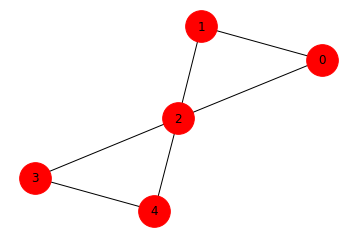

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

n = 5
V = np.arange(0, n, 1)
E =[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

default_axes = plt.axes(frameon=False, xticks=[], yticks=[])
pos = nx.spring_layout(G)

nx.draw_networkx(G, node_size=1000, alpha=1, ax=default_axes, pos=pos)